# Robot RR 2D con convención DH mod



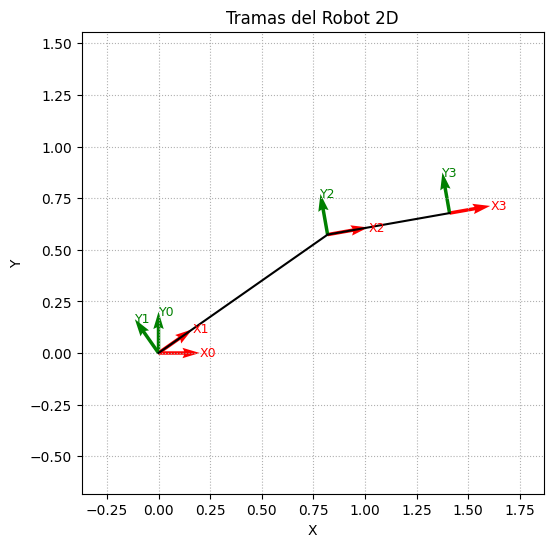

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def plot_frames_xy(T_list, axis_length=0.1, link_tol=1e-9, show=True, ax=None):

    # ---- Normalización de entrada ----
    T_arr = np.asarray(T_list)
    if T_arr.ndim != 3 or T_arr.shape[1:] != (4,4):
        raise ValueError("T_list debe ser de forma (N,4,4).")
    N = T_arr.shape[0]

    # ---- Preparar ejes ----
    created_ax = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))
        created_ax = True

    origins = T_arr[:, :2, 3]    # orígenes
    x_dirs  = T_arr[:, :2, 0]    # ejes X
    y_dirs  = T_arr[:, :2, 1]    # ejes Y

    # ---- Dibujar eslabones ----
    for i in range(1, N):
        p_prev = origins[i-1]
        p_curr = origins[i]
        if np.linalg.norm(p_curr - p_prev) > link_tol:
            ax.plot([p_prev[0], p_curr[0]], [p_prev[1], p_curr[1]], 'k-')

    # ---- Dibujar ejes y etiquetas ----
    for i in range(N):
        ox, oy = origins[i]
        dx, dy = axis_length * x_dirs[i]
        ux, uy = axis_length * y_dirs[i]

        # Eje X
        ax.quiver(ox, oy, dx, dy, angles='xy', scale_units='xy', scale=1.0, color='r')
        ax.text(ox + dx, oy + dy, f"X{i}", color='r',
                fontsize=9, ha='left', va='center')

        # Eje Y
        ax.quiver(ox, oy, ux, uy, angles='xy', scale_units='xy', scale=1.0, color='g')
        ax.text(ox + ux, oy + uy, f"Y{i}", color='g',
                fontsize=9, ha='left', va='center')

    # ---- Decoración ----
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, linestyle=':', linewidth=0.8)

    all_pts = np.vstack([origins,
                         origins + axis_length * x_dirs,
                         origins + axis_length * y_dirs])
    min_xy = all_pts.min(axis=0)
    max_xy = all_pts.max(axis=0)
    span = max(max_xy - min_xy)
    if span == 0:
        span = axis_length * 2
    center = (min_xy + max_xy) / 2.0
    margin = 0.15 * span
    ax.set_xlim(center[0] - span/2 - margin, center[0] + span/2 + margin)
    ax.set_ylim(center[1] - span/2 - margin, center[1] + span/2 + margin)
    ax.set_title('Tramas del Robot 2D')

    if show and created_ax:
        plt.show()

    return ax


# -------------------------
# Ejemplo de uso:
# Brazo planar de 2 eslabones (longitudes L1, L2) con ángulos q1, q2.
# -------------------------
if __name__ == "__main__":
    def Tz(R, t):
        """Construye una HTM 4x4 desde R (3x3) y t (3,)"""
        T = np.eye(4)
        T[:3,:3] = R
        T[:3, 3] = t
        return T

    def Rz(theta):
        c, s = np.cos(theta), np.sin(theta)
        R = np.eye(3)
        R[0,0], R[0,1] = c, -s
        R[1,0], R[1,1] = s,  c
        return R

    L1, L2 = 1.0, 0.6
    q1, q2 = np.deg2rad(35), np.deg2rad(-25)

    # Base
    T0 = np.eye(4)

    T1 = Tz(Rz(q1), np.array([0, 0.0, 0.0]))

    T2 = T1 @ Tz(Rz(q2), np.array([L1, 0.0, 0.0]))

    T3 = T2 @ Tz(np.eye(3), np.array([L2, 0.0, 0.0]))

    Ts = np.stack([T0, T1, T2, T3], axis=0)

    plot_frames_xy(Ts, axis_length=0.2)


# Robot RRR 3D con convención DH (clásica)

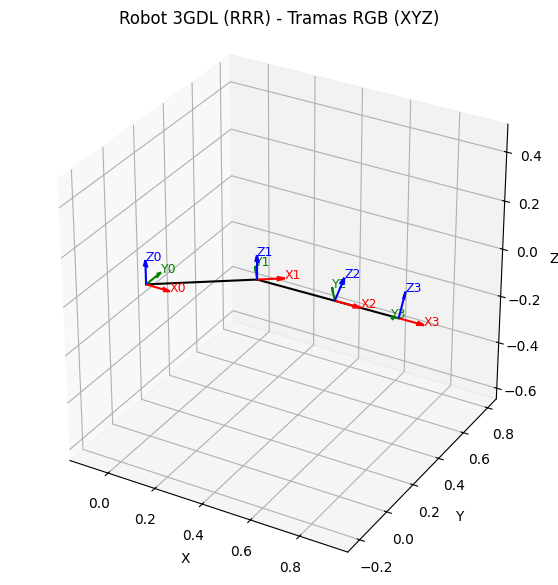

In [2]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (activa proyección 3D)

# --------------------------
# Utilidades de transformaciones (SE(3))
# --------------------------
def Rx(theta: float) -> np.ndarray:
    c, s = np.cos(theta), np.sin(theta)
    T = np.eye(4)
    T[:3,:3] = np.array([[1, 0, 0],
                         [0, c,-s],
                         [0, s, c]])
    return T

def Ry(theta: float) -> np.ndarray:
    c, s = np.cos(theta), np.sin(theta)
    T = np.eye(4)
    T[:3,:3] = np.array([[ c, 0, s],
                         [ 0, 1, 0],
                         [-s, 0, c]])
    return T

def Rz(theta: float) -> np.ndarray:
    c, s = np.cos(theta), np.sin(theta)
    T = np.eye(4)
    T[:3,:3] = np.array([[ c,-s, 0],
                         [ s, c, 0],
                         [ 0, 0, 1]])
    return T

def Trans(x=0.0, y=0.0, z=0.0) -> np.ndarray:
    T = np.eye(4)
    T[0,3], T[1,3], T[2,3] = x, y, z
    return T

# --------------------------
# Plot de tramas en 3D (RGB)
# --------------------------
def plot_frames_3d(T_list, axis_length=0.1, link_tol=1e-12, ax=None, show=True, title=None):
    """
    Dibuja tramas 3D a partir de una lista/array (N,4,4) de matrices homogéneas (SE(3)).
    - Eje X (rojo), Y (verde), Z (azul) con etiquetas Xi, Yi, Zi en la punta.
    - Segmentos negros entre orígenes consecutivos (eslabones) si hay traslación.
    """
    T_arr = np.asarray(T_list)
    if T_arr.ndim != 3 or T_arr.shape[1:] != (4,4):
        raise ValueError("T_list debe ser de forma (N,4,4).")

    created_ax = False
    if ax is None:
        fig = plt.figure(figsize=(7,7))
        ax = fig.add_subplot(111, projection='3d')
        created_ax = True

    # Origen y ejes locales
    origins = T_arr[:, :3, 3]        # (N, 3)
    x_dirs  = T_arr[:, :3, 0]        # (N, 3) eje X local
    y_dirs  = T_arr[:, :3, 1]        # (N, 3) eje Y local
    z_dirs  = T_arr[:, :3, 2]        # (N, 3) eje Z local

    # Dibujar ejes y etiquetas
    for i in range(T_arr.shape[0]):
        ox, oy, oz = origins[i]
        dx, dy, dz = axis_length * x_dirs[i]
        ux, uy, uz = axis_length * y_dirs[i]
        wx, wy, wz = axis_length * z_dirs[i]

        # X en rojo
        ax.quiver(ox, oy, oz, dx, dy, dz, length=1.0, normalize=False, color='r')
        ax.text(ox + dx, oy + dy, oz + dz, f"X{i}", color='r', fontsize=9)

        # Y en verde
        ax.quiver(ox, oy, oz, ux, uy, uz, length=1.0, normalize=False, color='g')
        ax.text(ox + ux, oy + uy, oz + uz, f"Y{i}", color='g', fontsize=9)

        # Z en azul
        ax.quiver(ox, oy, oz, wx, wy, wz, length=1.0, normalize=False, color='b')
        ax.text(ox + wx, oy + wy, oz + wz, f"Z{i}", color='b', fontsize=9)

    # Eslabones (segmentos negros entre orígenes)
    for i in range(1, origins.shape[0]):
        p0 = origins[i-1]
        p1 = origins[i]
        if np.linalg.norm(p1 - p0) > link_tol:
            ax.plot([p0[0], p1[0]], [p0[1], p1[1]], [p0[2], p1[2]], 'k-')

    # Decoración y límites
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Encajar límites alrededor de todas las puntas y orígenes
    all_pts = np.vstack([
        origins,
        origins + axis_length * x_dirs,
        origins + axis_length * y_dirs,
        origins + axis_length * z_dirs
    ])
    mins = all_pts.min(axis=0)
    maxs = all_pts.max(axis=0)
    center = (mins + maxs) / 2.0
    span = (maxs - mins).max()
    if span <= 0:
        span = axis_length * 2
    margin = 0.2 * span
    ax.set_xlim(center[0] - span/2 - margin, center[0] + span/2 + margin)
    ax.set_ylim(center[1] - span/2 - margin, center[1] + span/2 + margin)
    ax.set_zlim(center[2] - span/2 - margin, center[2] + span/2 + margin)

    # Aspecto cúbico
    try:
        ax.set_box_aspect((1,1,1))
    except Exception:
        pass

    if title:
        ax.set_title(title)

    if created_ax and show:
        plt.show()
    return ax

# --------------------------
# Ejemplo: robot 3GDL (RRR)
# Estructura tipo: Rz(q1) -> Trans(L1,0,0) -> Ry(q2) -> Trans(L2,0,0) -> Rx(q3) -> Trans(L3,0,0)
# Cada junta rota alrededor del eje local z, y, x respectivamente (tras cada transformación).
# --------------------------
def make_chain_3d_RRR(q1, q2, q3, L1, L2, L3):
    T0 = np.eye(4)
    T1 = T0 @ Rz(q1) @ Trans(L1, 0, 0)      # Junta 1 (z) + eslabón 1
    T2 = T1 @ Ry(q2) @ Trans(L2, 0, 0)      # Junta 2 (y) + eslabón 2
    T3 = T2 @ Rx(q3) @ Trans(L3, 0, 0)      # Junta 3 (x) + eslabón 3
    return np.stack([T0, T1, T2, T3], axis=0)

# --------------------------
# Demostración
# --------------------------
if __name__ == "__main__":
    # Parámetros de ejemplo (puedes cambiarlos libremente)
    L1, L2, L3 = 0.4, 0.3, 0.25
    q1 = np.deg2rad(35)   # rotación sobre z en la base
    q2 = np.deg2rad(20)   # rotación sobre y del frame 1
    q3 = np.deg2rad(-30)  # rotación sobre x del frame 2

    Ts = make_chain_3d_RRR(q1, q2, q3, L1, L2, L3)

    # Dibujo
    plot_frames_3d(Ts, axis_length=0.1, title="Robot 3GDL (RRR) - Tramas RGB (XYZ)")
